# Computational Social Science Project #2 

**Enter your Name:**Taylor Galdi

*Semester:* Fall 2024


Below we fill in some of the code you might use to answer some of the questions. Here are some additional resources for when you get stuck:
* Code and documentation provided in the course notebooks  
* [Markdown cheatsheet](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet) to help with formatting the Jupyter notebook
* Try Googling any errors you get and consult Stack Overflow, etc. Someone has probably had your question before!
* Send me a pull request on GitHub flagging the syntax that's tripping you up 

**INSTRUCTIONS:** For this project, copy all of the files in the Project 2 folder in the course repo into a "Project 2" subfolder within the "Computational Social Science Projects" directory that you created for the first project. You will work on the project locally, push your project to GitHub, and submit a link to the GitHub repo on bCourses by the project deadline. Be sure the final submission is in the main branch, which is what I'll pull down and re-run to grade. 

## 1. Introduction/Setup

#### a) Import relevant libraries
Here are some libraries you will need to get started. Along the way you may need to add more. Best practice is to add them here at the top of the script.

In [1]:
#
# import libraries you might need here 
#-----------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# use random seed for consistent results 
np.random.seed(273)

#### b) Read in and inspect data frame 
Read in the data frame and look at some of its attributes. Read in the data contained in the projoect folder: "Diabetes with Population Info by County 2017.csv".

In [2]:
#
# read in and inspect data frame
#-----------
# Note that "CountyFips" needs to be a string so the leading 0 isn't dropped (only if you want to make choropleth map) 
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv", 
                       dtype={"CountyFIPS": str}) 

In [3]:
#
# look at shape
#-----------
# look at the dimensions of the diabetes data frame
print('shape: ', diabetes.shape) 

shape:  (3220, 95)


In [4]:
#
# set pandas parameters
#-----------
# tells pandas how many rows to display when printing so results don't get truncated
pd.set_option('display.max_rows', 100)

# look at the data types for each column in diabetes df (likely be located under each row bc column names are long)
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                          object
Obesity_Number                                                                                                                                           object
Physical_Inactivity_Number                                                                                                                               object
sex and age_total population

Immediately, we see that some of the features that should be numeric (e.g., Diabetes_Number, Obesity_Number,  and Physical_Inactivity_Number) are not. We can check to see what the non-numeric values are in a column where we are expecting numeric information with a combination of `str.isnumeric()` and `unique()`.

In [5]:
#
# identify non-numeric features
#-----------
# Return rows where the column "Diabetes_Number" is non-numeric and get the unique values of these rows
# the "~" below in front of diabetes negates the str.isnumeric() so it only takes non-numeric values
print(diabetes[~diabetes["Diabetes_Number"].str.isnumeric()]["Diabetes_Number"].unique()) 

['Suppressed']


In [6]:
#
# Now do the same as above, but for "Obesity_Number"
#-----------
print(diabetes[~diabetes["Obesity_Number"].str.isnumeric()]["Obesity_Number"].unique()) 


['No Data']


In [7]:
#
# Now do the same as above, but for "Physical_Inactivity_Number" 
#-----------

print(diabetes[~diabetes["Physical_Inactivity_Number"].str.isnumeric()]["Physical_Inactivity_Number"].unique())

['No Data']


These values ("Suppresssed" and "No Data") contained in the two respective columns are coercing these features to objects instead of them being  integers. Let's drop those rows in the next section, and also recode "Physical_Inactivity_Number" feature to be an integer.

#### c. Recode variables

Convert 'Diabetes_Number', 'Obesity_Number', and 'Physical_Inactivity_Number' to integers below so we can use them in our analysis. Also fill in the object type we want to recode 'sex and age_total population_65 years and over_sex ratio (males per 100 females)' too (you'll have to scroll all the way over to the right).

In [8]:
#
# Recode variables
#-----------

# Diabetes
# ----------
# keep only useful info about our target feature, i.e., where diabetes_number not = 'Suppressed'
# note that the inside reference to the diabetes df identifies the column, and the outer calls specific rows according to a condition 
diabetes = diabetes[diabetes['Diabetes_Number']!="Suppressed"] 

# use the astype method on Diabetes_Number to convert it to an integer...if you are not sure, what does the astype() documentation tell you are possible arguments? 
diabetes["Diabetes_Number"] = diabetes["Diabetes_Number"].astype(int)

# Obesity
diabetes = diabetes[diabetes['Obesity_Number']!="No Data"] 
diabetes["Obesity_Number"] = diabetes["Obesity_Number"].astype(int)


# Physical Inactivity
diabetes = diabetes[diabetes["Physical_Inactivity_Number"]!="No Data"] 
diabetes["Physical_Inactivity_Number"] = diabetes["Physical_Inactivity_Number"].astype(int)


# Some final changes 
# ----------
# 65+ sex ratio had one "-" in it so let's drop that row first
diabetes = diabetes[diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)']!= "-"]

# change to numeric from string, since it originally included the "-", which made it a string
# you'll have to decide whether to make it integer or float 
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'].astype(float
                                                                                                                                                                                                )

We should probably scale our count variables to be proportional to county population. We create the list 'rc_cols' to select all the features we want to rescale, and then use the `.div()` method to avoid typing out every single column we want to recode. 

In [9]:
#
# Scale to county populations
#-----------

# select count variables to recode to percentages; make sure we leave out ratios and our population variable 
# because these don't make sense to scale by population
rc_cols = [col for col in diabetes.columns if col not in ['County', 'State', 'CountyFIPS', 
                                                        'sex and age_total population_65 years and over_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_sex ratio (males per 100 females)', 
                                                        'sex and age_total population_18 years and over_sex ratio (males per 100 females)',  
                                                        'race_total population']]
           
# recode all selected columns to numeric
diabetes[rc_cols] = diabetes[rc_cols].apply(pd.to_numeric, errors='coerce') 

# divide all columns but those listed above by total population to calculate rates
diabetes[rc_cols] = diabetes[rc_cols].div(diabetes['race_total population'], axis=0)

Let's check our work. Are all rates bounded by 0 and 1 as expected? 

In [10]:
#
# check
#-----------
# set pandas options
pd.set_option('display.max_columns', None)

# inspect recoded values
diabetes_summary = diabetes.describe().transpose() # note we use the transpose method rather than .T because this object is not a numpy array
  
# check recoding 
with pd.option_context('display.max_rows', 100, 'display.max_columns', None): 
    display(diabetes_summary.iloc[ : ,[0,1,3,7]]) # select which columns in the summary table we want to present

,count,mean,min,max
Diabetes_Number,3112.0,0.092857,0.019038,2.242079e-01
Obesity_Number,3112.0,0.251666,0.088946,4.767883e-01
Physical_Inactivity_Number,3112.0,0.200861,0.064949,3.922853e-01
sex and age_total population_65 years and over_sex ratio (males per 100 females),3112.0,84.275643,34.700000,2.200000e+02
race_total population,3112.0,103682.624036,228.000000,1.009805e+07
race_total population_one race,3112.0,0.976059,0.713126,1.000000e+00
race_total population_two or more races,3112.0,0.023941,0.000000,2.868743e-01
race_total population_one race_1,3112.0,0.976059,0.713126,1.000000e+00
race_total population_one race_white,3112.0,0.831107,0.038912,1.000000e+00
race_total population_one race_black or african american,3112.0,0.090215,0.000000,8.741228e-01


#### d. Check for duplicate columns

There are a lot of columns in this data frame. Let's see if there are any are duplicates. Note that Pandas will not allow them to have the same exact column name, so they will likely be distinct on column name but will be copies otherwise.

In [11]:
#
# Check for duplicate columns
#-----------
# I used Google to figure this out, and adapted this example for our purposes:  
# source: https://thispointer.com/how-to-find-drop-duplicate-columns-in-a-dataframe-python-pandas/ 
def getDuplicateColumns(df):
    '''
    Get a list of duplicate columns.
    It will iterate over all the columns in dataframe and find the columns whose contents are duplicate.
    :param df: Dataframe object
    :return: List of columns whose contents are duplicates.
    '''
    duplicateColumnNames = set()
    # Iterate over all the columns in dataframe
    for x in range(df.shape[1]):
        # Select column at xth index.
        col = df.iloc[:, x]
        # Iterate over all the columns in DataFrame from (x+1)th index till end
        for y in range(x + 1, df.shape[1]):
            # Select column at yth index.
            otherCol = df.iloc[:, y]
            # Check if two columns at x 7 y index are equal
            if col.equals(otherCol):
                duplicateColumnNames.add(df.columns.values[y])
    return list(duplicateColumnNames)

duplicateColumnNames = list(getDuplicateColumns(diabetes))
print('Duplicate Columns are as follows: ')
duplicateColumnNames

Duplicate Columns are as follows: 


['hispanic or latino and race_total population',
 'sex and age_total population_18 years and over_1',
 'race_total population_two or more races_1',
 'race_total population_one race_1',
 'sex and age_total population_65 years and over_1',
 'sex and age_total population']

In [12]:
#
# drop columns from duplicates list
#-----------
# now drop list of duplicate features from our df using the .drop() method
diabetes = diabetes.drop(columns=['sex and age_total population_65 years and over_1',
 'sex and age_total population',
 'sex and age_total population_18 years and over_1',
 'race_total population_one race_1',
 'race_total population_two or more races_1',
 'hispanic or latino and race_total population'])

Finally, there are many states accounted for the in dataset. If we convert this column to a categorical variable, and create dummies, it will create a rather sparse matrix (many 0s in our dataset) becuase there will be 49 dummy variables. One alternative is to classify each state to a larger US region and use that variable instead of state. The following code will do that.

In [13]:
# Define a dictionary mapping states to regions
state_to_region = {
    'Alabama': 'Southeast',
    'Alaska': 'West',
    'Arizona': 'West',
    'Arkansas': 'South',
    'California': 'West',
    'Colorado': 'West',
    'Connecticut': 'Northeast',
    'Delaware': 'Northeast',
    'District of Columbia': 'Southeast',
    'Florida': 'Southeast',
    'Georgia': 'Southeast',
    'Hawaii': 'West',
    'Idaho': 'West',
    'Illinois': 'Midwest',
    'Indiana': 'Midwest',
    'Iowa': 'Midwest',
    'Kansas': 'Midwest',
    'Kentucky': 'South',
    'Louisiana': 'South',
    'Maine': 'Northeast',
    'Maryland': 'Northeast',
    'Massachusetts': 'Northeast',
    'Michigan': 'Midwest',
    'Minnesota': 'Midwest',
    'Mississippi': 'South',
    'Missouri': 'Midwest',
    'Montana': 'West',
    'Nebraska': 'Midwest',
    'Nevada': 'West',
    'New Hampshire': 'Northeast',
    'New Jersey': 'Northeast',
    'New Mexico': 'West',
    'New York': 'Northeast',
    'North Carolina': 'Southeast',
    'North Dakota': 'Midwest',
    'Ohio': 'Midwest',
    'Oklahoma': 'South',
    'Oregon': 'West',
    'Pennsylvania': 'Northeast',
    'Rhode Island': 'Northeast',
    'South Carolina': 'Southeast',
    'South Dakota': 'Midwest',
    'Tennessee': 'South',
    'Texas': 'South',
    'Utah': 'West',
    'Vermont': 'Northeast',
    'Virginia': 'Southeast',
    'Washington': 'West',
    'West Virginia': 'South',
    'Wisconsin': 'Midwest',
    'Wyoming': 'West'
}

# Add a new 'Region' column based on the mapping
diabetes['Region'] = diabetes['State'].map(state_to_region)

# Print to verify'Region' column has been added
diabetes


,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some

## 2. Exploratory Data Analysis

Make at least two figures (feel free to make more) and explain their relevance to the scientific problem. The goal here is to uncover interesting patterns in the data, learn more about the scope of the problem, and communicate these findings to your audience in clear ways.

<Axes: xlabel='Physical_Inactivity_Number', ylabel='Diabetes_Number'>

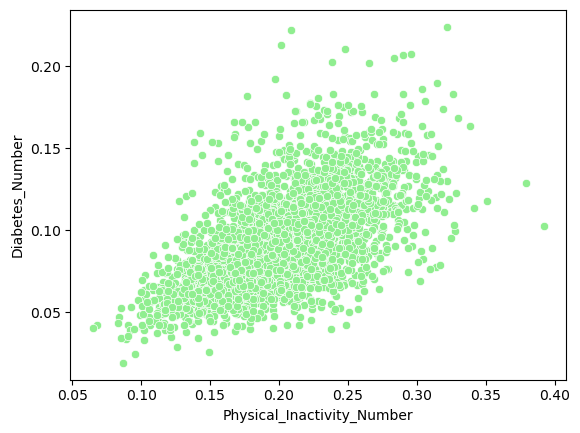

In [14]:
#
# EDA #1 and interpretations in this section 
# This scatterplot looks at the relationship between Physical Inactivity and Diabetes Rates
sns.scatterplot(x = "Physical_Inactivity_Number", 
            y = "Diabetes_Number", 
            data = diabetes, 
            color = "lightgreen")

<Axes: xlabel='Region', ylabel='Diabetes_Number'>

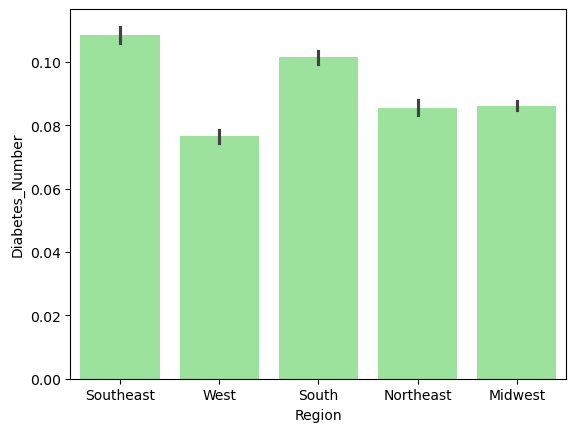

In [15]:
#
# EDA #2 and interpretations in this section 
# This barplot looks at the relationship between Regions of the United States and Diabetes Rates
sns.barplot(x = "Region", 
            y = "Diabetes_Number", 
            data = diabetes, 
            color = "lightgreen")


<Axes: xlabel='Obesity_Number', ylabel='Diabetes_Number'>

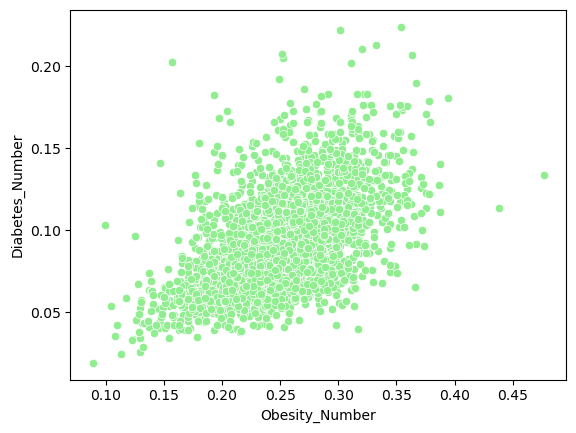

In [16]:
# EDA #3 and interpretations in this section
# This scatterplot looks at the relationship between Obesity Rates and Diabetes Rates
sns.scatterplot(x = "Obesity_Number", 
            y = "Diabetes_Number", 
            data = diabetes, 
            color = "lightgreen")

## 3. Prepare to Fit Models

### 3.1 Finalize Data Set

We've already cleaned up the data, but we can make a few more adjustments before partitioning the data and training models. Let's recode 'Region' to be a categorical variable using `pd.get_dummies` and drop 'State'. Also, we'll drop 'County' because 'CountyFIPS' is already a unique identifier for the county. 

In [17]:
#
# Drop and get dummies
#-----------

# create dummy features out of 'Region', which might be related to diabetes rates 
diabetes_clean = pd.get_dummies(diabetes, 
                               columns = ["Region"],  
                               drop_first = True) # drop the first as a reference 

# drop 'County' and 'State' variables
diabetes_clean = diabetes_clean.drop(labels = ["County", "State"],
                               axis = 1) # which axis tells python we want to drop columns rather than index rows?
##Axis 1!

# look at first 10 rows of new data frame 
diabetes_clean.head(10)

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

In [18]:
#I see that the first 10 are from the Southeast, I want to check that our recoding worked for our whole sample 
# look at first 10 rows of new data frame 
diabetes_clean.tail(10)
##Great, I see the last ten are from the West!

,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -

In [19]:
print('data types:', diabetes.dtypes)

data types: County                                                                                                                                                   object
State                                                                                                                                                    object
CountyFIPS                                                                                                                                               object
Diabetes_Number                                                                                                                                         float64
Obesity_Number                                                                                                                                          float64
Physical_Inactivity_Number                                                                                                                              float64
sex and age_total population

### 3.2 Partition Data, Feature Selection, and Standardization

Now, we will partition our data to prepare it for the training process. Ultimately we want to use a 60% train—20% validation—20% test in this case. More data in the training set lowers bias, but then increases variance in the validation/test sets. Balancing between bias and variance with choice of these set sizes is important as we want to ensure that there is enough data to train on to get good predictions, but also want to make sure our hold-out sets are representative enough.

Work through partitioning the data into the test/train/validation sets in the chunks below. Be sure to that if you are using Ridge or LASSO, you Standardize the data. Where you do this in the workflow matters so be clear about where you are doing this and why. 

In [20]:
#
# Partition data
#-----------

# import library
from sklearn.model_selection import train_test_split

# create y dataframe 
y = diabetes_clean["Diabetes_Number"]

# create X dataframe (include everything except "Diabetes_Number", our target, 
# and "race alone or in combination with one or more other races_total population")
X = diabetes_clean.drop(["Diabetes_Number","race alone or in combination with one or more other races_total population" ], 
                axis = 1) # refers to columns
X.head()

,CountyFIPS,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,race_total population_one race_white,race_total population_one race_black or african american,race_total population_one race_american indian and alaska native,race_total population_one race_american indian and alaska native_cherokee tribal grouping,race_total population_one race_american indian and alaska native_chippewa tribal grouping,race_total population_one race_american indian and alaska native_navajo tribal grouping,race_total population_one race_american indian and alaska native_sioux tribal grouping,race_total population_one race_asian,race_total population_one race_asian_asian indian,race_total population_one race_asian_chinese,race_total population_one race_asian_filipino,race_total population_one race_asian_japanese,race_total population_one race_asian_korean,race_total population_one race_asian_vietnamese,race_total population_one race_asian_other asian,race_total population_one race_native hawaiian and other pacific islander,race_total population_one race_native hawaiian and other pacific islander_native hawaiian,race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro,race_total population_one race_native hawaiian and other pacific islander_samoan,race_total population_one race_native hawaiian and other pacific islander_other pacific islander,race_total population_one race_some other race,race_total population_two or more races_white and black or african american,race_total population_two or more races_white and american indian and alaska native,race_total population_two or more races_white and asian,race_total population_two or more races_black or african american and american indian and alaska native,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,race alone or in combination with one or more other races_total population_some other race,hispanic or latino and race_total population_hispanic or latino (of any race),hispanic or latino and race_total population_hispanic or latino (of any race)_mexican,hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican,hispanic or latino and race_total population_hispanic or latino (of any race)_cuban,hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino,hispanic or latino and race_total population_not hispanic or latino,hispanic or latino and race_total population_not hispanic or latino_white alone,hispanic or latino and race_total population_not hispanic or latino_black or african american alone,hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone,hispanic or latino and race_total population_not hispanic or latino_asian alone,hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone,hispanic or latino and race_total population_not hispanic or latino_some other race alone,hispanic or latino and race_total population_not hispanic or latino_two or more races,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race,hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race - and three or more races,total housing units,citizen - voting age population_citizen - 18 a

Investigate whether there are any features that you should remove prior to spliting and model fitting. You may also consider using plots and relationships you found in the EDA stage for this question. Be sure to justify your logic. 

In [21]:
#
# Feature selection
#-----------
X = diabetes_clean.drop(columns=["race_total population_one race_american indian and alaska native_cherokee tribal grouping",                                                                
"race_total population_one race_american indian and alaska native_chippewa tribal grouping",                                                                
"race_total population_one race_american indian and alaska native_navajo tribal grouping",                                                                  
"race_total population_one race_american indian and alaska native_sioux tribal grouping",  
"race_total population_one race_asian_asian indian",                                                                                                        
"race_total population_one race_asian_chinese",                                                                                                             
"race_total population_one race_asian_filipino",                                                                                                            
"race_total population_one race_asian_japanese",                                                                                                            
"race_total population_one race_asian_korean",                                                                                                              
"race_total population_one race_asian_vietnamese",                                                                                                          
"race_total population_one race_asian_other asian",                                                                                                         
"race_total population_one race_native hawaiian and other pacific islander",                                                                                
"race_total population_one race_native hawaiian and other pacific islander_native hawaiian",                                                                
"race_total population_one race_native hawaiian and other pacific islander_guamanian or chamorro",                                                         
"race_total population_one race_native hawaiian and other pacific islander_samoan",                                                                         
"race_total population_one race_native hawaiian and other pacific islander_other pacific islander",  
"race_total population_two or more races_white and black or african american",                                                                              
"race_total population_two or more races_white and american indian and alaska native",                                                                      
"race_total population_two or more races_white and asian",                                                                                                  
"race_total population_two or more races_black or african american and american indian and alaska native",               
"hispanic or latino and race_total population_hispanic or latino (of any race)_mexican",                                                                    
"hispanic or latino and race_total population_hispanic or latino (of any race)_puerto rican",                                                               
"hispanic or latino and race_total population_hispanic or latino (of any race)_cuban",                                                                      
"hispanic or latino and race_total population_hispanic or latino (of any race)_other hispanic or latino",                                                                             
"hispanic or latino and race_total population_not hispanic or latino_white alone",                                                                          
"hispanic or latino and race_total population_not hispanic or latino_black or african american alone",                                                      
"hispanic or latino and race_total population_not hispanic or latino_american indian and alaska native alone",                                              
"hispanic or latino and race_total population_not hispanic or latino_asian alone",                                                                          
"hispanic or latino and race_total population_not hispanic or latino_native hawaiian and other pacific islander alone",                                     
"hispanic or latino and race_total population_not hispanic or latino_some other race alone",                                                                
"hispanic or latino and race_total population_not hispanic or latino_two or more races",                                                                    
"hispanic or latino and race_total population_not hispanic or latino_two or more races_two races including some other race",                                
"hispanic or latino and race_total population_not hispanic or latino_two or more races_two races excluding some other race -  and three or more races",   
"sex and age_total population_sex ratio (males per 100 females)",                                                                                           
"sex and age_total population_under 5 years",                                                                                                               
"sex and age_total population_5 to 9 years",                                                                                                                
"sex and age_total population_10 to 14 years",                                                                                                              
"sex and age_total population_15 to 19 years",                                                                                                              
"sex and age_total population_20 to 24 years",                                                                                                              
"sex and age_total population_25 to 34 years",                                                                                                              
"sex and age_total population_35 to 44 years",                                                                                                              
"sex and age_total population_45 to 54 years",                                                                                                              
"sex and age_total population_55 to 59 years",                                                                                                              
"sex and age_total population_60 to 64 years",                                                                                                              
"sex and age_total population_65 to 74 years",                                                                                                              
"sex and age_total population_75 to 84 years",                                                                                                              
"sex and age_total population_85 years and over",                                                                                                                                                                                                                                                                                                                     
"sex and age_total population_16 years and over",                                                                                                           
"sex and age_total population_18 years and over",                                                                                                           
"sex and age_total population_21 years and over",                                                                                                           
"sex and age_total population_62 years and over",                                                                                                           
"sex and age_total population_65 years and over",                                                                                                                                                                                                            
"sex and age_total population_18 years and over_sex ratio (males per 100 females)","Diabetes_Number","race alone or in combination with one or more other races_total population", "citizen -  voting age population_citizen -  18 and over population_male","citizen -  voting age population_citizen -  18 and over population_female"], axis = 1)  



In [22]:
#
# Training/test split
#-----------

# set the random seed
np.random.seed(10)


# split the data so that it returns 4 values: X_train, X_test, y_train, y_test
X_train, X_test, y_train, y_test = train_test_split(X,                 # specify training dataset
                                                    y,                 # specify test dataset
                                                    train_size=0.8,      # specify proportional split for training
                                                    test_size=0.2)       # specify proportional split for test

In [23]:
#
# Validation split
#-----------

# train_test_split returns 4 values: X_train, X_test, y_train, y_test, so how do we create a 60-20-20 train-validate-test split? 
X_train, X_validate, y_train, y_validate =  train_test_split(X_train, 
                                                            y_train,
                                                            train_size=0.75, 
                                                            test_size=0.25)

In [24]:
#
# Standardization
#-----------
# Given that we want to only standardize non-dichotomous variables, we need to find a 
# solution that will loop over only the columns we want to standardize. The code below
# identifies all non-dichotomous variables in our dataset and only standardizes those.

# load library and create instance of Standard Scaler 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# identify non-dichotomous columns we want to transform
columns = list(X_test.select_dtypes(include=['number']).loc[:, X_test.nunique() > 2])

# use loop to transform training data for only columns we want to transform
for column in columns:
    X_train[column] = scaler.fit_transform(X_train[column].values.reshape(-1, 1)).flatten()

# use loop to transform validation data for only columns we want to transform
for column in columns:
    X_validate[column] = scaler.fit_transform(X_validate[column].values.reshape(-1, 1)).flatten()

# use loop to transform test data for only columns we want to transform
for column in columns:
    X_test[column] = scaler.fit_transform(X_test[column].values.reshape(-1, 1)).flatten()

## 4. Train Models

In this section, train your models. 

**Note that if you use Lasso, you will likely need to specify a very low penalty (e.g., an alpha of 0.001) because of convergence problems.**

### 4.1 Describe models

Detail the basic logic and assumptions underlying each model, its pros/cons, and why it is a plausible choice for this problem.

**MODEL DESCRIPTION(S):** ...
#insert descriptions

### 4.2 Train models

Train each model in the training set, and be sure to tune hyperparameters if appropriate. Report any relevant summary statistics from the training set, including how well each model fits the training data.

#### Model 1:  (enter name of model here) 

In [25]:
# load libraries 
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

# use magic function
%matplotlib inline


# set style
sns.set_style("darkgrid")

In [26]:
#
# Model 1 training
# create a model
lin_reg = LinearRegression()

# fit the model
lin_model = lin_reg.fit(X_train, y_train)




In [27]:
# print model coefficients and intercept
print(lin_model.coef_)
print(lin_model.intercept_)

[-5.10876379e-08  8.30335713e-03  7.22203962e-03  4.81250818e-03
  3.53825922e-04  9.96689431e-04 -9.96689431e-04 -2.78608397e-02
  4.53861414e-03  1.65184659e-02  1.78733173e-02 -4.98905925e-03
  3.85953840e-02  1.10905384e-02 -9.16078165e-03 -1.89040587e-02
  4.68559587e-03  7.11644338e-03  5.56012749e-04 -5.56012749e-04
 -2.08840433e-04  3.27347436e-03  1.47612827e-04 -1.47612827e-04
 -1.55618140e-03  1.24363382e-03 -1.35786219e-03  2.37071032e-05
 -8.13975289e-03  1.25166051e-02  3.95109742e-03  9.89477458e-03
  1.04995893e-02  3.81207730e-03]
0.08980393836114853


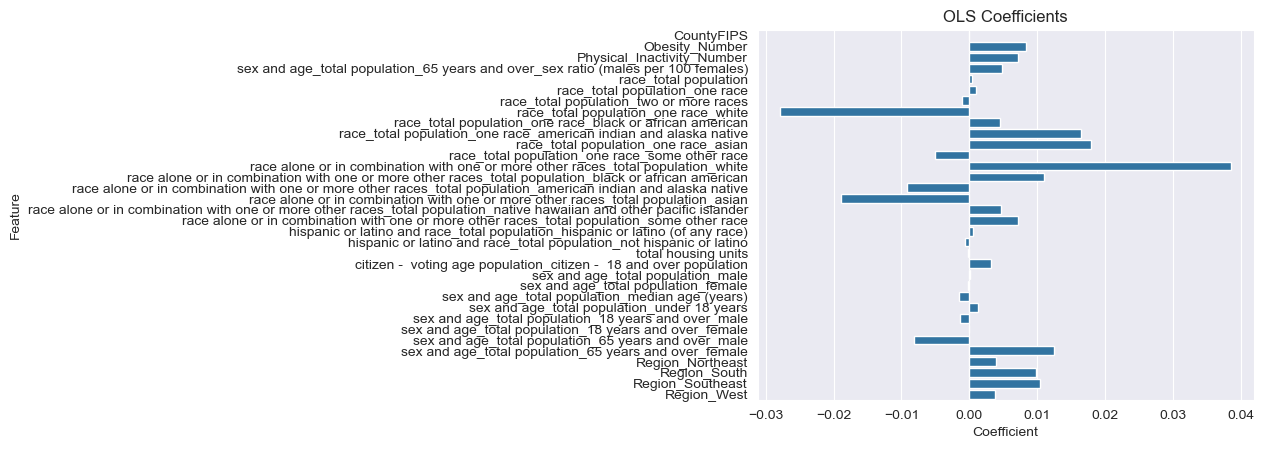

In [28]:
# create a dataframe with the coefficient and feature names for plotting
lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T # make a dataframe from the arrays
lin_reg_data.columns = ['Coefficient', 'Feature']           # add column names for clarity

# plot
ax = sns.barplot(x="Coefficient",                           # add x 
                 y="Feature",                               # add y
                 data=lin_reg_data)                         # specify data

ax.set_title("OLS Coefficients")                            # set title
plt.show()                                                  # show plot

In [29]:
# see parameters for linear regression
lin_reg.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

#### Model 2:  (enter name of model here) 

In [30]:
#
# Model 2 training
#-----------
# make and fit a Ridge regression model
ridge_reg = Ridge()                                              # create the model
ridge_model = ridge_reg.fit(X_train, y_train)                    # fit the model

# create a dataframe with the coefficient and feature names for plotting
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T  # create a dataframe from the estimates
ridge_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity

Text(0.5, 1.0, 'Ridge Coefficients')

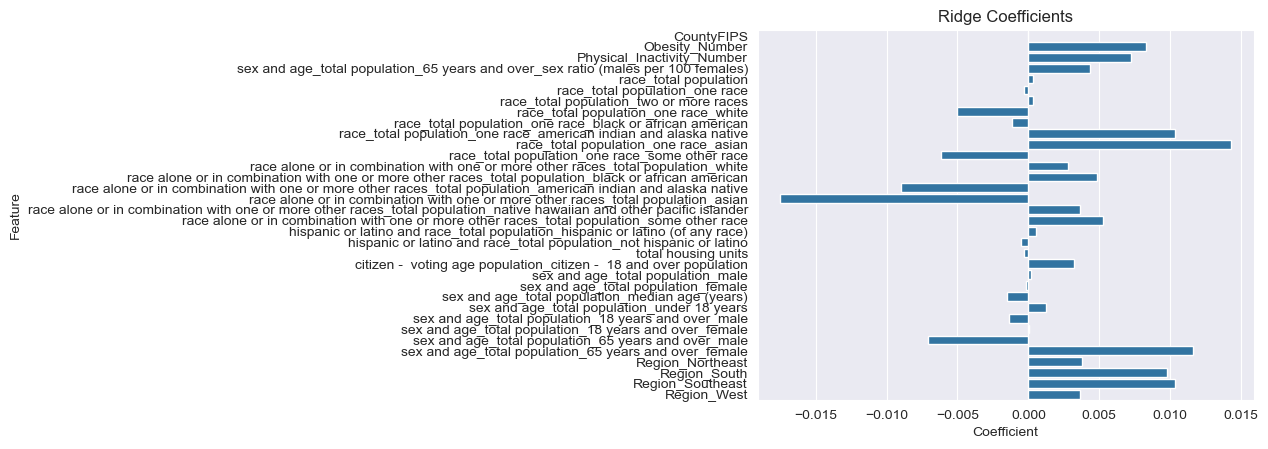

In [31]:
# set the figure parameters 
figure = plt.figure()                            # set the figure space
figure.subplots_adjust(wspace = .8, hspace=.5)   # adjust the space in between figures 



# specify barplot for Ridge
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=ridge_reg_data).set_title("Ridge Coefficients")



In [32]:
# see parameters for Ridge regression
ridge_reg.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

#### Model 3:  (enter name of model here) 

In [33]:
#
# Model 3 training
#-----------
# create and fit the model
lasso_reg = Lasso(alpha=0.001,max_iter=15000)  # note the hypterparameter tuning will not converge with max_iter < 15000
lasso_model = lasso_reg.fit(X_train, 
                            y_train)

# create a dataframe with the coefficient and feature names for plotting
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T  # create a dataframe from the estimates
lasso_reg_data.columns = ['Coefficient', 'Feature']              # add column names for clarity


Text(0.5, 1.0, 'LASSO Coefficients')

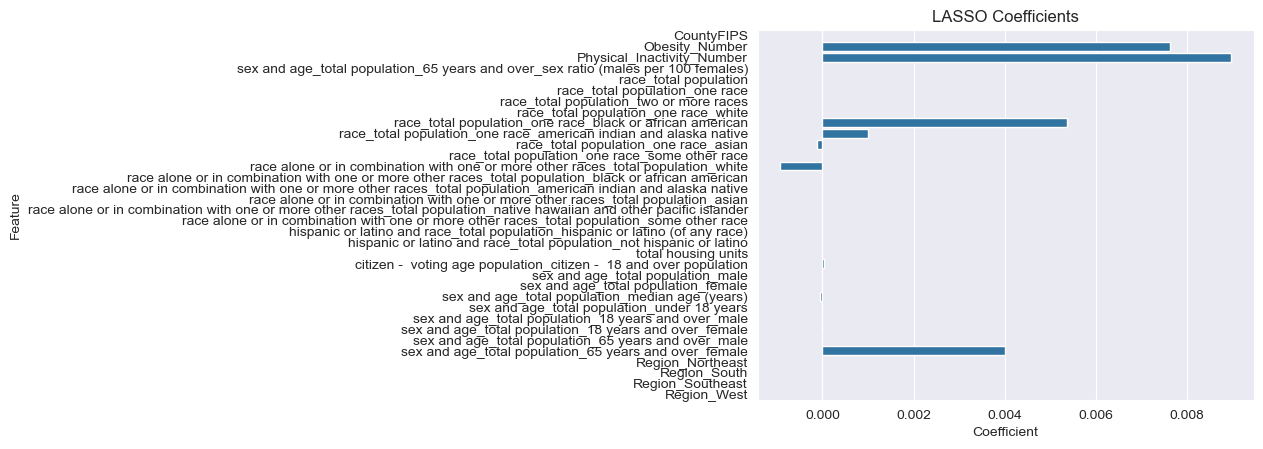

In [34]:

# specify barplot for LASSO 
sns.barplot(x="Coefficient", 
            y="Feature", 
            data=lasso_reg_data).set_title("LASSO Coefficients")


In [35]:
lasso_reg.get_params()

{'alpha': 0.001,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': 15000,
 'positive': False,
 'precompute': False,
 'random_state': None,
 'selection': 'cyclic',
 'tol': 0.0001,
 'warm_start': False}

In [36]:
# LASSO 
#----------- 

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

In [37]:
lasso_grid_reg.get_params()

{'cv': 3,
 'error_score': nan,
 'estimator__alpha': 0.001,
 'estimator__copy_X': True,
 'estimator__fit_intercept': True,
 'estimator__max_iter': 15000,
 'estimator__positive': False,
 'estimator__precompute': False,
 'estimator__random_state': None,
 'estimator__selection': 'cyclic',
 'estimator__tol': 0.0001,
 'estimator__warm_start': False,
 'estimator': Lasso(alpha=0.001, max_iter=15000),
 'n_jobs': None,
 'param_grid': {'alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
  'fit_intercept': [True, False],
  'selection': ['cyclic', 'random']},
 'pre_dispatch': '2*n_jobs',
 'refit': True,
 'return_train_score': False,
 'scoring': None,
 'verbose': 0}

## 5. Validate and Refine Models

### 5.1 Predict on the validation set
Using each of the models you trained, predict outcomes in the validation set. Evaluate how well each model did.

### Linear Regression


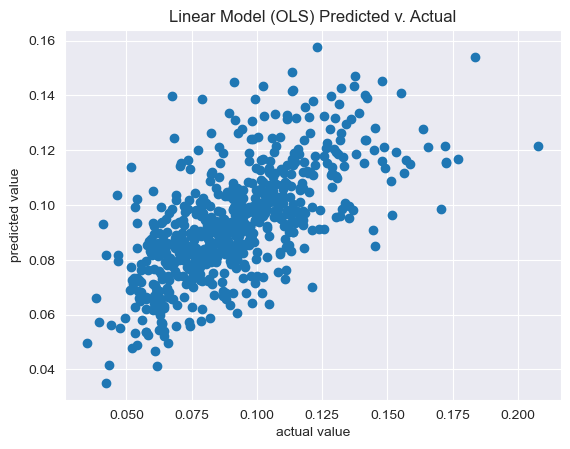

In [38]:
#
# Predict on validation data
#-----------
lin_pred = lin_model.predict(X_validate)

# plot the residuals on a scatter plot
plt.scatter(y_validate, lin_pred)                    # specify x and y of the scatter plot
plt.title('Linear Model (OLS) Predicted v. Actual')  # specify plot title
plt.xlabel('actual value')                           # specify x-axis label
plt.ylabel('predicted value')                        # specify y-axis label
plt.show()                                           # show plot


In [39]:
# create function to calculate the root mean squared errror
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

In [40]:
# calculate root mean squared errror
rmse(lin_pred,     # specify predicted values 
     y_validate)   # specify actual values values 

0.019959385199627536

### RIDGE


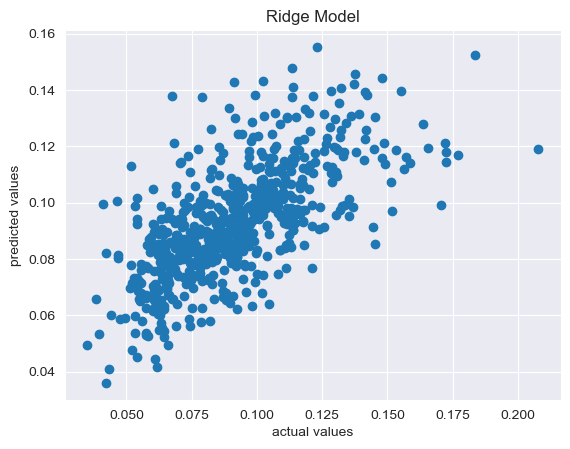

In [41]:
# use the model to make predictions
ridge_pred = ridge_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [42]:
# calculate the rmse for the Ridge model
rmse(ridge_pred, y_validate)

0.019774720491643596

### LASSO 


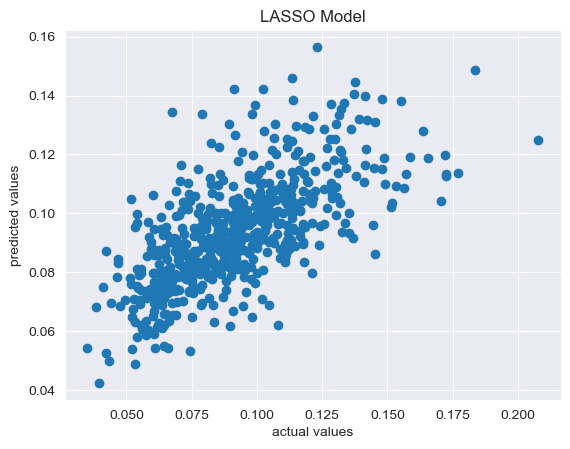

In [43]:
# use the model to make predictions
lasso_pred = lasso_model.predict(X_validate)

# plot the predictions
plt.scatter(y_validate, lasso_pred)

# add title and labels
plt.title('LASSO Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

In [44]:
# calculate the rmse for the LASSO model
rmse(lasso_pred, y_validate)

0.01945558371702626

### 5.2 Predict on the test set

Now, choose your best performing model of the three, select out unimportant feature(s), retrain the model, and then predict on the test set. 

In [47]:
#
# RIDGE 
#-----------
# We will run 9*2*4 = 72 tests, each with 3-fold cross validation

# specify the hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

# execute the grid search
ridge_grid_reg = GridSearchCV(ridge_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# fit the tuning on the training data
ridge_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])  # find the best performing model
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)   # find best estimator and predict on validate

# print the results  
print(ridge_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

{'alpha': 0.9, 'fit_intercept': True, 'solver': 'auto'}
Best CV R^2: 0.4976013742015309
Validation R^2: 0.4221463345896389
Validation RMSE 0.01978391524773544


In [57]:
# Best Ridge model 

# pick the best estimator and predict on test
ridge_best_pred = ridge_grid_reg.best_estimator_.predict(X_test)

# print various results
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', ridge_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(ridge_best_pred, y_test))

Best CV R^2: 0.4976013742015309
Test R^2: 0.4385938350456148
Test RMSE 0.020650672071527376


In [49]:
ridge_grid_reg.cv_results_["mean_test_score"]

array([ 4.96377774e-01,  4.96377774e-01,  4.96377774e-01, -1.28587692e-03,
       -7.92674890e-01, -7.92674890e-01, -7.92674890e-01, -2.22392997e+00,
        4.96765150e-01,  4.96765150e-01,  4.96765150e-01, -1.28587692e-03,
       -7.91294066e-01, -7.91294066e-01, -7.91294066e-01, -2.22392997e+00,
        4.96980174e-01,  4.96980174e-01,  4.96980174e-01, -1.28587692e-03,
       -7.90785228e-01, -7.90785228e-01, -7.90785228e-01, -2.22392997e+00,
        4.97136352e-01,  4.97136352e-01,  4.97136352e-01, -1.28587692e-03,
       -7.90493894e-01, -7.90493894e-01, -7.90493894e-01, -2.22392997e+00,
        4.97261463e-01,  4.97261463e-01,  4.97261463e-01, -1.28587692e-03,
       -7.90283272e-01, -7.90283272e-01, -7.90283272e-01, -2.22392997e+00,
        4.97366166e-01,  4.97366166e-01,  4.97366166e-01, -1.28587692e-03,
       -7.90111294e-01, -7.90111294e-01, -7.90111294e-01, -2.22392997e+00,
        4.97455784e-01,  4.97455784e-01,  4.97455784e-01, -1.28587692e-03,
       -7.89961901e-01, -

In [50]:
param_grid = {'alpha': np.arange(.1, 1, .1),
              'fit_intercept': [True, False],
              'selection': ['cyclic', 'random']}

# execute the grid search
lasso_grid_reg = GridSearchCV(lasso_reg,  # model to be tuned
                              param_grid, # parameters to be searched as specified above
                              cv=3)       # 3-fold cross-validation to be used during hypertuning

# now fit the tuning on the training data
lasso_grid_reg.fit(X_train, y_train)

# select the best performing model and predict with that on validation dataset 
best_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])   # find the best performing model
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)    # find best estimator and predict on validate

# print results
print(lasso_grid_reg.cv_results_["params"][best_index])
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

{'alpha': 0.1, 'fit_intercept': True, 'selection': 'cyclic'}
Best CV R^2: -0.0012865425853822627
Validation R^2: 0.001292167120310883
Validation RMSE 0.026008932928432527


In [58]:
# Best LASSO model

# pick the best estimator and predict on test
lasso_best_pred = lasso_grid_reg.best_estimator_.predict(X_test)

# print various results
print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', lasso_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(lasso_best_pred, y_test))

Best CV R^2: -0.0012865425853822627
Test R^2: -0.008004432258441607
Test RMSE 0.02767112539323057


### 5.3 Impement a cross-validation approach

Finally, implement a cross-validation approach for your best model and evaluate the results.

In [ ]:
#
# Run cross-validation
#-----------



## 6. Discussion Questions

In this section, insert responses for discussion questions here.

1. What is bias-variance tradeoff? Why is it relevant to machine learning problems like this one?

**YOUR ANSWER HERE**...

2. Define overfitting, and why it matters for machine learning. How can we address it?

**YOUR ANSWER HERE**...

3. Discuss your analysis in 2-3 paragraphs. Discuss your findings and recommendations. Which counties or regions would you prioritize for the pilot program? Would your answers change based on whether you want to take into account certain features such as race, gender, or age composition in the county? How confident would you be deploying this sort of model in a real-world application – why or why not?

**YOUR ANSWER HERE**...